Part A

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math

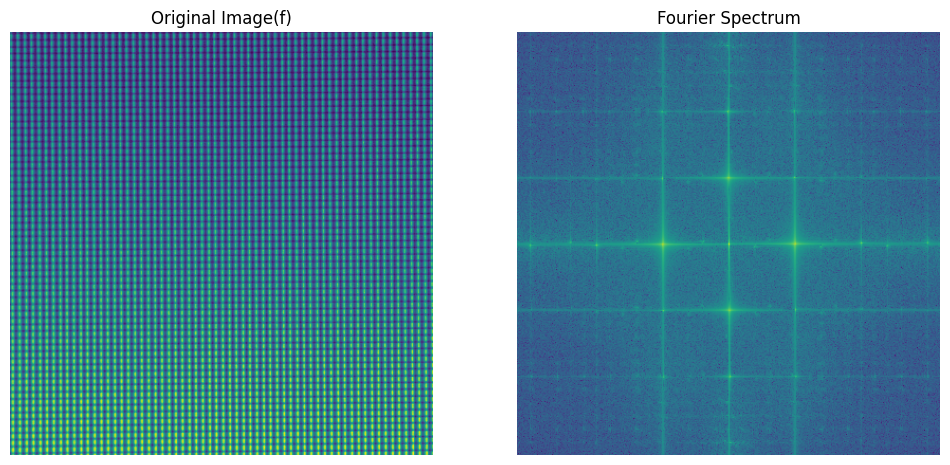

In [8]:
image = cv2.imread('close_up2.jpg', cv2.IMREAD_GRAYSCALE)

fft = np.fft.fft2(image) #using inbuilt fourier
fft_shift = np.fft.fftshift(fft)
magnitude_spectrum = np.log(np.abs(fft_shift) + 1)  #taking log of spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image(f)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum)
plt.title('Fourier Spectrum')
plt.axis('off')

plt.show()

image shape: (400, 400)
BLI shape: (120, 120)


(-0.5, 119.5, 119.5, -0.5)

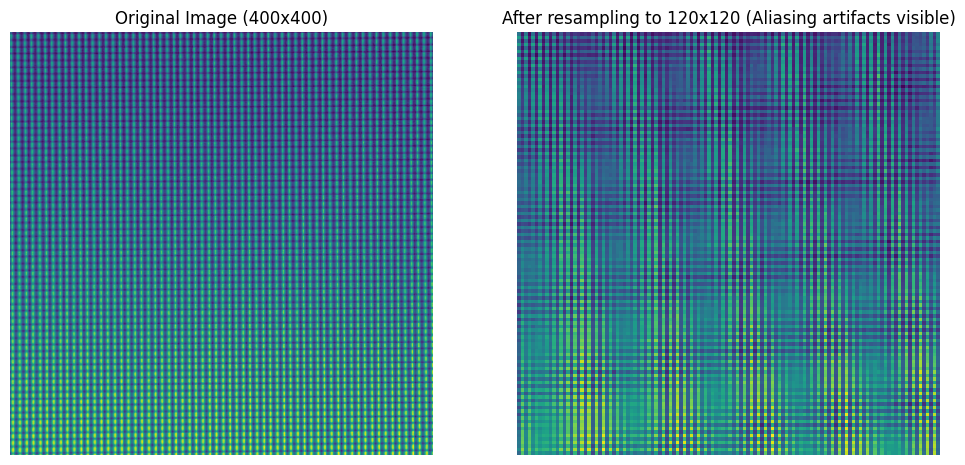

In [9]:
def BLInterpolationDownSampled(Img, factor):
    OriginalHeight, OriginalWidth = Img.shape[:2]
    Height = int(OriginalHeight * factor)
    Width = int(OriginalWidth * factor)

    Answer = np.zeros((Height, Width), dtype=Img.dtype)

    for i in range(Height):
        for j in range(Width):
            x = i / factor
            y = j / factor
            x1 = int(x)
            y1 = int(y)
            x2 = min(x1 + 1, OriginalHeight - 1)
            y2 = min(y1 + 1, OriginalWidth - 1)

            a = x - x1
            b = y - y1
            Answer[i, j] = ( (1 - a) * (1 - b) * Img[x1, y1] + a * (1 - b) * Img[x2, y1] + (1 - a) * b * Img[x1, y2] + a * b * Img[x2, y2] )

    return Answer


DownSampled = BLInterpolationDownSampled(image, 0.3)
print("image shape:",image.shape)
print("BLI shape:", DownSampled.shape)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image (400x400)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(DownSampled)
plt.title('After resampling to 120x120 (Aliasing artifacts visible)')
plt.axis('off')


image shape: (400, 400)
Upsampled shape: (480, 480)


(-0.5, 479.5, 479.5, -0.5)

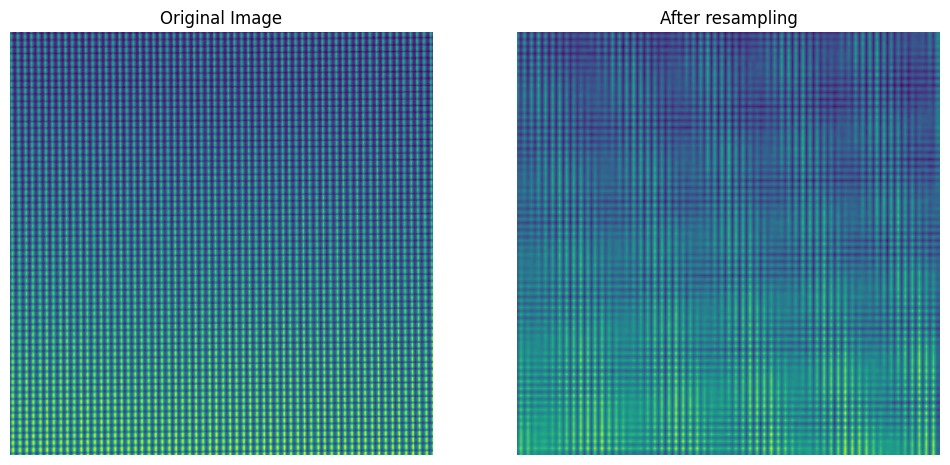

In [10]:
# This part is to check if aliasing done well or not.
def BLInterpolationUpSampling(Img, factor):
    OriginalHeight, OriginalWidth = Img.shape[:2]
    Height = OriginalHeight * factor
    Width = OriginalWidth * factor

    Answer = np.zeros((Height, Width), dtype=Img.dtype)

    for i in range(Height):
        for j in range(Width):
            x = i / factor
            y = j / factor
            x1 = int(x)
            y1 = int(y)
            x2 = min(x1 + 1, OriginalHeight - 1)
            y2 = min(y1 + 1, OriginalWidth - 1)
            a = x - x1
            b = y - y1
            Answer[i, j] = ( (1 - a) * (1 - b) * Img[x1, y1] + a * (1 - b) * Img[x2, y1] + (1 - a) * b * Img[x1, y2] + a * b * Img[x2, y2] )

    return Answer

UpSampled = BLInterpolationUpSampling(DownSampled, 4)
print("image shape:",image.shape)
print("Upsampled shape:", UpSampled.shape)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(UpSampled)
plt.title('After resampling')
plt.axis('off')

Part B

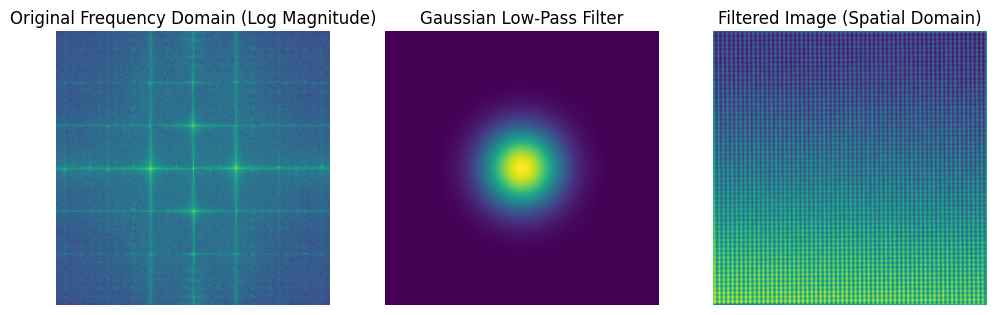

(-0.5, 119.5, 119.5, -0.5)

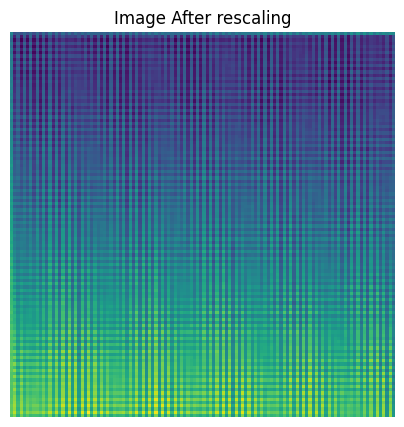

In [11]:
# Function to create a Gaussian low-pass filter in Frequency domain
def GaussianLowPassFilter(shape, cutoff):
    rows, cols = shape
    x = np.linspace(-0.5, 0.5, cols)
    y = np.linspace(-0.5, 0.5, rows)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2)
    gaussian_filter = np.exp(-(D**2) / (2 * (cutoff**2)))

    return gaussian_filter

def ApplyFilter(dft_image, filter_mask):
    return dft_image * filter_mask

def DisplayFilteredImage(dft_image, cutoff_frequency):
    rows, cols = dft_image.shape
    gaussian_filter = GaussianLowPassFilter((rows, cols), cutoff_frequency)
    filtered_dft_image = ApplyFilter(dft_image, gaussian_filter)
    shifted_filtered_dft = np.fft.ifftshift(filtered_dft_image)  #used inbuilt function for FFT
    filtered_image = np.fft.ifft2(shifted_filtered_dft)  #Used inbuilt function for inverse of FFT
    filtered_image_magnitude = np.abs(filtered_image)
    
    #Dislay the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(np.log(np.abs(dft_image) + 1))
    plt.title('Original Frequency Domain (Log Magnitude)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gaussian_filter)
    plt.title('Gaussian Low-Pass Filter')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(filtered_image_magnitude)
    plt.title('Filtered Image (Spatial Domain)')
    plt.axis('off')

    plt.show()

    return filtered_image_magnitude

ImageAfterLowPassFilter=DisplayFilteredImage(fft_shift, 0.1)
ImageAfterLowPassFilterAndDownSampled=BLInterpolationDownSampled(ImageAfterLowPassFilter, 0.3)
plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.imshow(ImageAfterLowPassFilterAndDownSampled)
plt.title('Image After rescaling')
plt.axis('off')


Part C

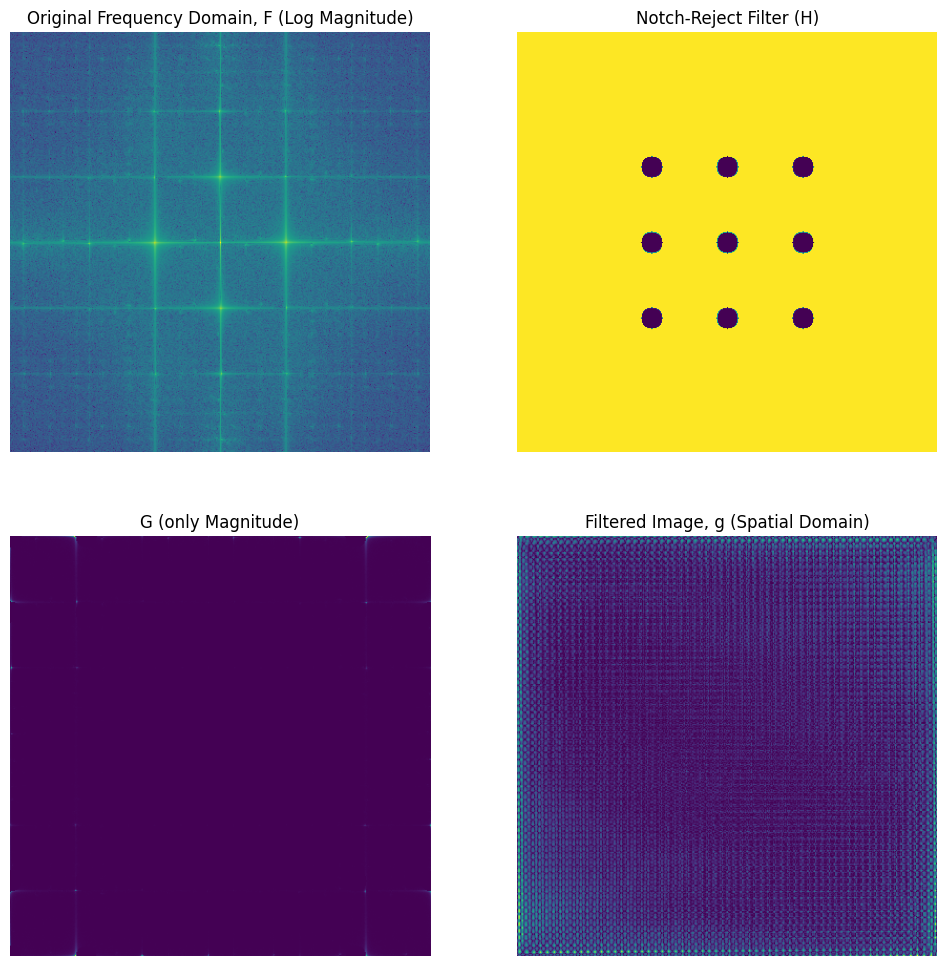

In [14]:
def NotchRejectFilter(shape, d0, centers):
    rows, cols = shape
    notch_filter = np.ones((rows, cols))
    for center in centers:
        u0, v0 = center

        for u in range(rows):
            for v in range(cols):
                D = np.sqrt((u - u0)**2 + (v - v0)**2)
                if D <= d0:
                    notch_filter[u, v] = 0

    return notch_filter

def ApplyFilter(dft_image, filter_mask):
    return dft_image * filter_mask

def DisplayFilteredImage(dft_image, d0, notch_centers):
    rows, cols = dft_image.shape

    notch_filter = NotchRejectFilter((rows, cols), d0, notch_centers)

    filtered_dft_image = ApplyFilter(dft_image, notch_filter)

    shifted_filtered_dft = np.fft.ifftshift(filtered_dft_image)

    filtered_image = np.fft.ifft2(shifted_filtered_dft)
    
    filtered_image_magnitude = np.abs(filtered_image)


    #Dislay the images
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.imshow(np.log(np.abs(dft_image) + 1))
    plt.title('Original Frequency Domain, F (Log Magnitude)')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(notch_filter)
    plt.title('Notch-Reject Filter (H)')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(np.abs(shifted_filtered_dft))
    plt.title('G (only Magnitude)')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(filtered_image_magnitude)
    plt.title('Filtered Image, g (Spatial Domain)')
    plt.axis('off')

    plt.show()

#Notch radius
d0 = 10
# Coordinates of the frequency to remove (Manually defined)
notch_centers = [(128, 128), (200, 200), (128, 200), (200, 128), (272, 200), (200, 272), (272, 272), (272, 128), (128, 272)] 

DisplayFilteredImage(fft_shift, d0, notch_centers)

Part D

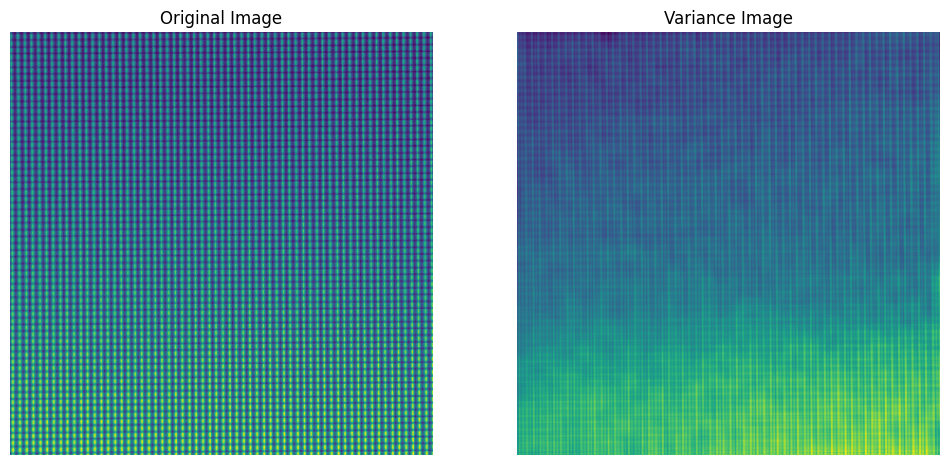

In [15]:
def IntegralImage(image):
    return np.cumsum(np.cumsum(image, axis=0), axis=1)

def WindowSum(integral, x1, y1, x2, y2):
    return (integral[x2, y2] - (integral[x1-1, y2] if x1 > 0 else 0) - (integral[x2, y1-1] if y1 > 0 else 0) + (integral[x1-1, y1-1] if x1 > 0 and y1 > 0 else 0))

def ComputeVarianceImage(f, window_size):
    M, N = f.shape
    m, n = window_size

    f_integral = IntegralImage(f)
    f2_integral = IntegralImage(f**2)

    var_image = np.zeros_like(f, dtype=float)

    half_m, half_n = m // 2, n // 2

    for i in range(M):
        for j in range(N):
            x1, y1 = max(i - half_m, 0), max(j - half_n, 0)
            x2, y2 = min(i + half_m, M - 1), min(j + half_n, N - 1)

            area = (x2 - x1 + 1) * (y2 - y1 + 1)

            sum_f = WindowSum(f_integral, x1, y1, x2, y2)
            sum_f2 = WindowSum(f2_integral, x1, y1, x2, y2)

            mean_f = sum_f / area
            mean_f2 = sum_f2 / area

            var_image[i, j] = mean_f2 - mean_f**2

    return var_image


image_normalized = image.astype(np.float64) / 255.0

window_size = (15, 15)

variance_image = ComputeVarianceImage(image_normalized, window_size)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(variance_image)
plt.title('Variance Image')
plt.axis('off')

plt.show()


Part E

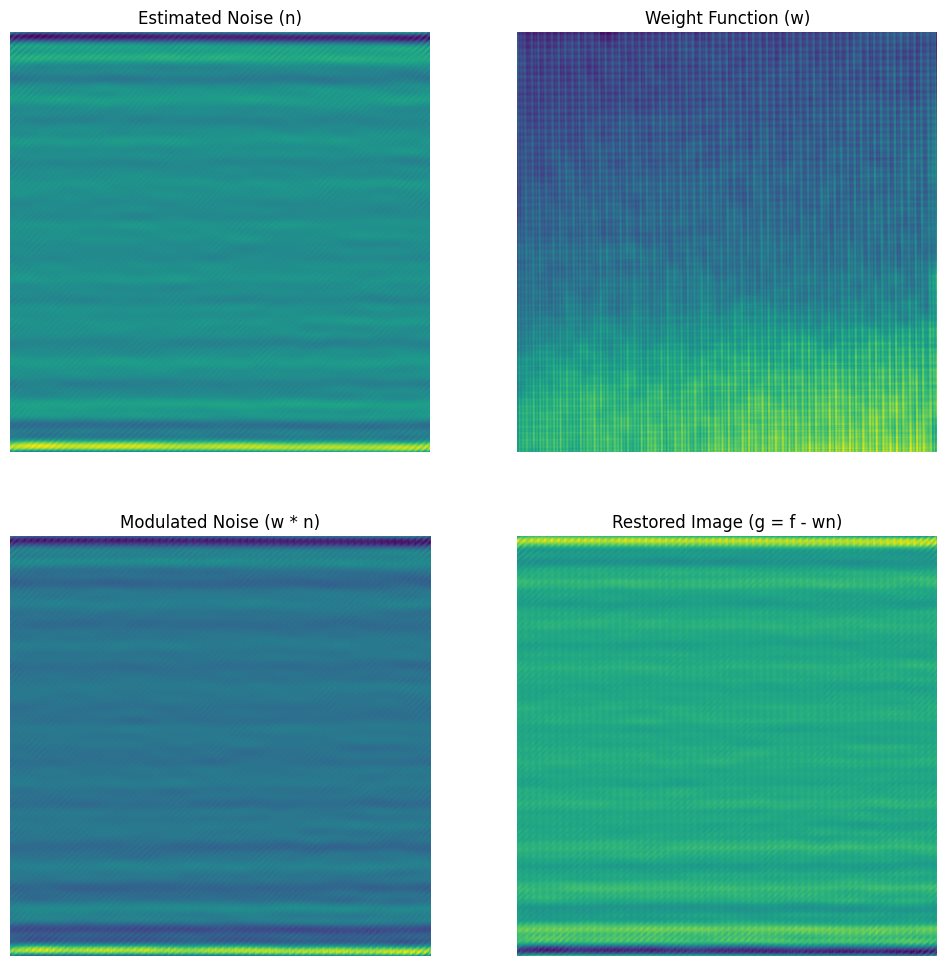

In [16]:

def ApplyNotchFilter(dft_image, d0, notch_centers):
    rows, cols = dft_image.shape
    notch_filter = NotchRejectFilter((rows, cols), d0, notch_centers)
    filtered_dft_image = ApplyFilter(dft_image, notch_filter)
    return filtered_dft_image, notch_filter

d0 = 10  #Noth radius
notch_centers = [(128, 128), (180, 200)]
filtered_dft_image, notch_filter = ApplyNotchFilter(fft_shift, d0, notch_centers)

estimated_noise_dft = fft_shift - filtered_dft_image
window_size = (15, 15) #Window size 15x15
variance_image = ComputeVarianceImage(image_normalized, window_size)
weight_function = variance_image / np.max(variance_image)

# Used inbuilt FFT and inverse FFT
estimated_noise = np.fft.ifft2(np.fft.ifftshift(estimated_noise_dft)).real
modulated_noise = weight_function * estimated_noise
restored_image = image_normalized - modulated_noise


plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(estimated_noise)
plt.title('Estimated Noise (n)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(weight_function)
plt.title('Weight Function (w)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(modulated_noise)
plt.title('Modulated Noise (w * n)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(restored_image)
plt.title('Restored Image (g = f - wn)')
plt.axis('off')

plt.show()
